<a href="https://colab.research.google.com/github/munnisha0620/BWLO-AGE-PREDICTION/blob/main/Project_bonage_neat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
 ! pip install -q kaggle

In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"tharimunnishashaik","key":"1db43d4c47b9ab8b3090e5917535b5f9"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

ref                                                                 title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
amanbarthwal/imdb-movies-data                                       IMDB Movies Dataset                                   8MB  2024-05-16 18:43:48           1572         26  1.0              
rahulvyasm/netflix-movies-and-tv-shows                              Netflix Movies and TV Shows                           1MB  2024-04-10 09:48:38          23081        504  1.0              
vladimirmijatovic/data-scientists-salaries-worldwide-annual-survey  Data Scientists Salaries Worldwide - Annual Survey   51KB  2024-05-19 19:41:14           1012         31  1.0              
jainaru/world-happiness-report-2024-year

In [ ]:
!kaggle datasets download -d kmader/rsna-bone-age


Dataset URL: https://www.kaggle.com/datasets/kmader/rsna-bone-age
License(s): other
100% 9.26G/9.29G [02:11<00:00, 119MB/s]
100% 9.29G/9.29G [02:11<00:00, 75.6MB/s]


In [ ]:
# Make directory for the dataset and unzip the downloaded file
!mkdir -p /content/Dataset
!unzip -q rsna-bone-age.zip -d /content/Dataset

# Remove the zip file to save space
!rm rsna-bone-age.zip

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import datetime, os
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from skimage.io import imread
import os
from glob import glob
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.xception import preprocess_input as xception_preprocess_input

from tensorflow.keras.layers import GlobalMaxPooling2D, Dense,Flatten, Dropout
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras import Sequential , layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2, EfficientNetB4, VGG16, xception


In [ ]:
#loading dataframes
train_df = pd.read_csv('/content/Dataset/boneage-training-dataset.csv')

#appending file extension to id column for both training and testing dataframes
train_df['id'] = train_df['id'].apply(lambda x: str(x)+'.png')

train_df.head()

,id,boneage,male
0,1377.png,180,False
1,1378.png,12,False
2,1379.png,94,False
3,1380.png,120,True
4,1381.png,82,False


# Feature Engineering

## Examine the distribution of age and gender

gender
male      6833
female    5778
Name: count, dtype: int64


<Axes: xlabel='gender', ylabel='count'>

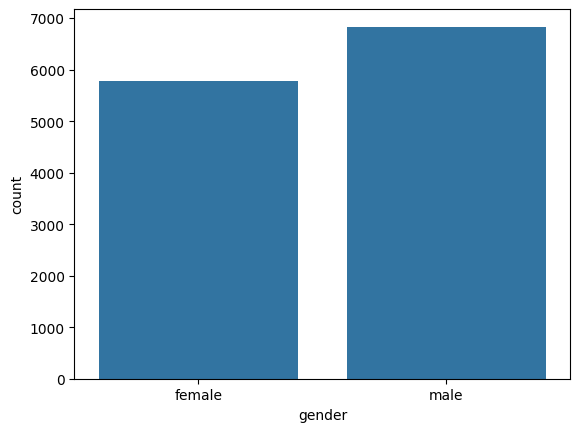

In [ ]:
train_df['gender'] = train_df['male'].apply(lambda x: 'male' if x else 'female')
print(train_df['gender'].value_counts())
sns.countplot(x = train_df['gender'])

Text(0.5, 1.0, 'Number of people in each age group')

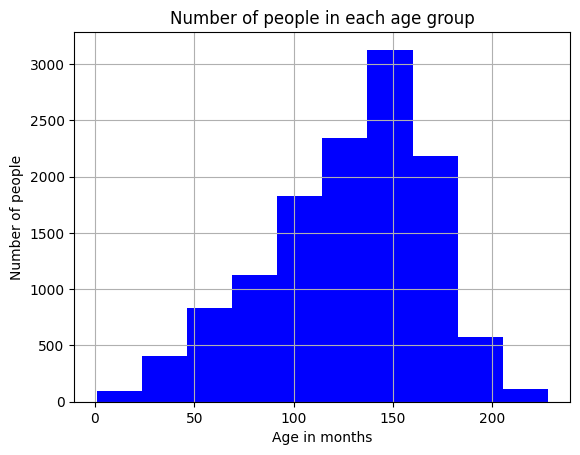

In [ ]:
#plotting a histogram for bone ages
train_df['boneage'].hist(color = 'blue')
plt.xlabel('Age in months')
plt.ylabel('Number of people')
plt.title('Number of people in each age group')

In [ ]:
#oldest person in the dataset
print('MAX age: ' + str(train_df['boneage'].max()) + ' months')

#youngest person in the dataset
print('MIN age: ' + str(train_df['boneage'].min()) + ' months')

#mean age is
mean_bone_age = train_df['boneage'].mean()
print('mean: ' + str(mean_bone_age))

#median bone age
print('median: ' +str(train_df['boneage'].median()))

#standard deviation of boneage
std_bone_age = train_df['boneage'].std()

train_df['bone_age_z'] = (train_df['boneage'] - mean_bone_age)/(std_bone_age)

print(train_df.head())

MAX age: 228 months
MIN age: 1 months
mean: 127.3207517246848
median: 132.0
         id  boneage   male  gender  bone_age_z
0  1377.png      180  False  female    1.279181
1  1378.png       12  False  female   -2.800269
2  1379.png       94  False  female   -0.809109
3  1380.png      120   True    male   -0.177766
4  1381.png       82  False  female   -1.100498


In [ ]:
#splitting train dataframe into traininng and validation dataframes
df_train, df_valid = train_test_split(train_df, test_size = 0.25, random_state = 0)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd


# Ensure the path to the directory is correct and contains the image files
image_dir = '/content/Dataset/boneage-training-dataset/boneage-training-dataset'

for filename, boneage, gender in train_df[['id', 'boneage', 'gender']].sample(4).values:
    # Construct the file path correctly with file extension
    img_path = f'{image_dir}{filename}.png'

    try:
        # Read and display the image
        img = mpimg.imread(img_path)
        plt.imshow(img, cmap='gray')  # Use cmap='gray' for grayscale images
        plt.title(f'Image name: {filename}  Bone age: {boneage / 12:.2f} years  Gender: {gender}')
        plt.axis('off')
        plt.show()
    except FileNotFoundError:
        print(f"File not found: {img_path}")


File not found: /content/Dataset/boneage-training-dataset/boneage-training-dataset4268.png.png
File not found: /content/Dataset/boneage-training-dataset/boneage-training-dataset13538.png.png
File not found: /content/Dataset/boneage-training-dataset/boneage-training-dataset6679.png.png
File not found: /content/Dataset/boneage-training-dataset/boneage-training-dataset9157.png.png


# image preprocessing

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.xception import preprocess_input as xception_preprocess_input

# Load and preprocess the data
train_df = pd.read_csv('/content/Dataset/boneage-training-dataset.csv')
train_df['id'] = train_df['id'].apply(lambda x: str(x) + '.png')
train_df['gender'] = train_df['male'].apply(lambda x: 'male' if x else 'female')

# Normalize bone age
mean_bone_age = train_df['boneage'].mean()
std_bone_age = train_df['boneage'].std()
train_df['bone_age_z'] = (train_df['boneage'] - mean_bone_age) / std_bone_age

# Define image size and batch size
img_size = 128
batch_size = 32

# Data generators with augmentation
data_generator = ImageDataGenerator(
    preprocessing_function=xception_preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)


# K-Fold Cross-Validation
k = 10
kf = KFold(n_splits=k, shuffle=True, random_state=42)


#DRN Model

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Add, Activation, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

# Define the DRN architecture
def build_model(img_size):
    inputs = Input(shape=(img_size, img_size, 3))

    # Initial convolutional layer
    x = Conv2D(64, kernel_size=7, activation='relu', padding='same')(inputs)
    x = MaxPooling2D()(x)

    # Residual blocks
    for _ in range(3):
        residual = x
        x = Conv2D(64, kernel_size=3, activation='relu', padding='same')(x)
        x = Conv2D(64, kernel_size=3, activation='relu', padding='same')(x)
        x = Add()([x, residual])
        x = Activation('relu')(x)

    # Pooling layer
    x = MaxPooling2D()(x)

    # Additional Convolutional layers
    x = Conv2D(128, kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling2D()(x)

    # Dense layers
    x = GlobalAveragePooling2D()(x)
    x = Dense(64, activation='relu')(x)

    # Output layer
    outputs = Dense(1, activation='linear')(x)

    # Define model
    model = Model(inputs=inputs, outputs=outputs)

    return model


# Beluga whale lion optimization

In [ ]:
import numpy as np
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping

# Define objective function for BWLO optimization
def objective_function(model, hyperparameters, train_data, val_data, early_stopping):
    learning_rate, momentum = hyperparameters
    optimizer = SGD(learning_rate=learning_rate, momentum=momentum, clipnorm=1.0)  # Added gradient clipping
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_error'])
    history = model.fit(train_data[0], train_data[1], validation_data=(val_data[0], val_data[1]), epochs=50, callbacks=[early_stopping], verbose=0)
    return min(history.history['val_loss']), min(history.history['val_mean_absolute_error'])

# Define BWLO algorithm
def BWLO(model, num_iterations, num_beluga_whales, num_lions, search_space, max_iter_without_improvement, train_data, val_data):
    beluga_whales = np.random.uniform(
        [search_space['learning_rate'][0], search_space['momentum'][0]],
        [search_space['learning_rate'][1], search_space['momentum'][1]],
        size=(num_beluga_whales, 2)
    )
    lions = np.random.uniform(
        [search_space['learning_rate'][0], search_space['momentum'][0]],
        [search_space['learning_rate'][1], search_space['momentum'][1]],
        size=(num_lions, 2)
    )
    best_fitness = float('inf')
    best_mae = float('inf')
    best_hyperparameters = None
    best_iter = 0
    iter_without_improvement = 0
    early_stopping = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)

    for iteration in range(num_iterations):
        beluga_whale_results = [objective_function(model, hyperparameters, train_data, val_data, early_stopping) for hyperparameters in beluga_whales]
        lion_results = [objective_function(model, hyperparameters, train_data, val_data, early_stopping) for hyperparameters in lions]

        beluga_whale_fitness = [result[0] for result in beluga_whale_results]
        beluga_whale_mae = [result[1] for result in beluga_whale_results]
        lion_fitness = [result[0] for result in lion_results]
        lion_mae = [result[1] for result in lion_results]

        min_beluga_whale_fitness = min(beluga_whale_fitness)
        min_lion_fitness = min(lion_fitness)

        if min_beluga_whale_fitness < best_fitness:
            best_fitness = min_beluga_whale_fitness
            best_mae = beluga_whale_mae[np.argmin(beluga_whale_fitness)]
            best_hyperparameters = beluga_whales[np.argmin(beluga_whale_fitness)]
            best_iter = iteration
            iter_without_improvement = 0
        elif min_lion_fitness < best_fitness:
            best_fitness = min_lion_fitness
            best_mae = lion_mae[np.argmin(lion_fitness)]
            best_hyperparameters = lions[np.argmin(lion_fitness)]
            best_iter = iteration
            iter_without_improvement = 0
        else:
            iter_without_improvement += 1

        if iter_without_improvement >= max_iter_without_improvement:
            break

        beluga_whales += np.random.uniform(-0.01, 0.01, size=beluga_whales.shape)
        lions += np.random.uniform(-0.01, 0.01, size=lions.shape)
        beluga_whales = beluga_whales[np.argsort(beluga_whale_fitness)]
        lions = lions[np.argsort(lion_fitness)]
        beluga_whales[:num_beluga_whales // 2] = np.random.uniform(
            [search_space['learning_rate'][0], search_space['momentum'][0]],
            [search_space['learning_rate'][1], search_space['momentum'][1]],
            size=(num_beluga_whales // 2, 2)
        )
        lions[:num_lions // 2] = np.random.uniform(
            [search_space['learning_rate'][0], search_space['momentum'][0]],
            [search_space['learning_rate'][1], search_space['momentum'][1]],
            size=(num_lions // 2, 2)
        )

        print(f"Iteration {iteration + 1}: Best Fitness - {best_fitness}")

    return best_hyperparameters, best_fitness, best_mae, best_iter

# Define search space for BWLO
search_space = {'learning_rate': (0.001, 0.01), 'momentum': (0.5, 0.9)}
num_iterations = 10
num_beluga_whales = 5
num_lions = 3
max_iter_without_improvement = 5

# **Validation**

In [ ]:
fold_results = []
mae_results = []

for train_index, val_index in kf.split(train_df):
    df_train = train_df.iloc[train_index]
    df_valid = train_df.iloc[val_index]

    train_generator = data_generator.flow_from_dataframe(
        dataframe=df_train,
        directory='/content/Dataset/boneage-training-dataset/boneage-training-dataset',
        x_col='id',
        y_col='bone_age_z',
        batch_size=batch_size,
        seed=42,
        shuffle=True,
        class_mode='other',
        target_size=(img_size, img_size)
    )

    val_generator = data_generator.flow_from_dataframe(
        dataframe=df_valid,
        directory='/content/Dataset/boneage-training-dataset/boneage-training-dataset',
        x_col='id',
        y_col='bone_age_z',
        batch_size=batch_size,
        seed=42,
        shuffle=True,
        class_mode='other',
        target_size=(img_size, img_size)
    )

    # Values for train_generator and val_generator
    train_X, train_Y = next(train_generator)
    val_X, val_Y = next(val_generator)

    # Normalize the data
    train_X = train_X / 255.0
    val_X = val_X / 255.0

    model = build_model(img_size)

    # Run BWLO optimization
    best_hyperparameters, best_fitness, best_mae, best_iter = BWLO(
        model, num_iterations, num_beluga_whales, num_lions, search_space, max_iter_without_improvement, (train_X, train_Y), (val_X, val_Y))

    # Store results for each fold
    fold_results.append({
        'best_hyperparameters': best_hyperparameters,
        'best_fitness': best_fitness,
        'best_iter': best_iter
    })
    mae_results.append(best_mae)

    # Evaluate on validation set
    val_predictions = model.predict(val_X).flatten()
    val_predictions_binary = (val_predictions > 0.5).astype(int)
    val_Y_binary = (val_Y > 0.5).astype(int)

# Display fold results
for i, result in enumerate(fold_results):
    print(f"Fold {i + 1}: Best Hyperparameters - {result['best_hyperparameters']}, Best Fitness - {result['best_fitness']}, Best Iteration - {result['best_iter']}")

# Calculate mean and standard deviation of MAE
mean_mae = np.mean(mae_results)
std_mae = np.std(mae_results)

# Print mean and standard deviation of all metrics
print("\nMean Results:")
print("Mean Absolute Error (MAE):", mean_mae)
print("\nStandard Deviation:")
print("Mean Absolute Error (MAE):", std_mae)


Found 11349 validated image filenames.
Found 1262 validated image filenames.


Iteration 1: Best Fitness - 1.1942250728607178
Iteration 2: Best Fitness - 1.1942145824432373
Iteration 3: Best Fitness - 1.1942143440246582
Iteration 4: Best Fitness - 1.1942143440246582
Iteration 5: Best Fitness - 1.1942143440246582
Iteration 6: Best Fitness - 1.1942143440246582
Iteration 7: Best Fitness - 1.1942143440246582
1/1 [==============================] - 2s 2s/step
Found 11350 validated image filenames.
Found 1261 validated image filenames.
Iteration 1: Best Fitness - 1.0842934846878052
Iteration 2: Best Fitness - 1.0573111772537231
Iteration 3: Best Fitness - 1.0572271347045898
Iteration 4: Best Fitness - 1.0572271347045898
Iteration 5: Best Fitness - 1.0572271347045898
Iteration 6: Best Fitness - 1.0572271347045898
Iteration 7: Best Fitness - 1.0572271347045898
1/1 [==============================] - 2s 2s/step
Found 11350 validated image filenames.
Found 1261 validated image filenames.
Iteration 1: Best Fitness - 0.8947440385818481
Iteration 2: Best Fitness - 0.89474403858

1/1 [==============================] - 2s 2s/step
Found 11350 validated image filenames.
Found 1261 validated image filenames.
Iteration 1: Best Fitness - 1.217335820198059
Iteration 2: Best Fitness - 1.0428798198699951
Iteration 3: Best Fitness - 1.0428533554077148
Iteration 4: Best Fitness - 1.0428533554077148
Iteration 5: Best Fitness - 1.0428533554077148
Iteration 6: Best Fitness - 1.0428533554077148
Iteration 7: Best Fitness - 1.0428533554077148


1/1 [==============================] - 3s 3s/step
Found 11350 validated image filenames.
Found 1261 validated image filenames.
Iteration 1: Best Fitness - 1.0878136157989502
Iteration 2: Best Fitness - 1.0878102779388428
Iteration 3: Best Fitness - 1.0878050327301025
Iteration 4: Best Fitness - 1.0878050327301025
Iteration 5: Best Fitness - 1.0878050327301025
Iteration 6: Best Fitness - 1.0878050327301025
Iteration 7: Best Fitness - 1.0878050327301025
1/1 [==============================] - 2s 2s/step
Found 11350 validated image filenames.
Found 1261 validated image filenames.
Iteration 1: Best Fitness - 1.0531615018844604
Iteration 2: Best Fitness - 1.0531615018844604
Iteration 3: Best Fitness - 1.0531615018844604
Iteration 4: Best Fitness - 1.0531615018844604
Iteration 5: Best Fitness - 1.0531615018844604
1/1 [==============================] - 1s 1s/step
Found 11350 validated image filenames.
Found 1261 validated image filenames.
Iteration 1: Best Fitness - 0.7182376384735107
Iteratio

In [ ]:
# Calculate error percentage based on MAE
error_percentage_mae = (mean_mae_months / bone_age_range) * 100

print(f"Error Percentage based on MAE: {error_percentage_mae:.2f}%")
# Calculate error percentage based on MSE
error_percentage_mse = (np.sqrt(mean_mse_months) / bone_age_range) * 100

print(f"Error Percentage based on MSE: {error_percentage_mse:.2f}%")
# Calculate total error (MAE or RMSE) and total data range
total_error_mae = mean_mae_months
total_error_rmse = np.sqrt(mean_mse_months)
total_data_range = bone_age_range

# Calculate accuracy based on MAE
accuracy_mae = max(0, min(100, (1 - (total_error_mae / total_data_range)) * 100))

# Calculate accuracy based on RMSE
accuracy_rmse = max(0, min(100, (1 - (total_error_rmse / total_data_range)) * 100))

print(f"Accuracy based on MAE: {accuracy_mae:.2f}%")
print(f"Accuracy based on RMSE: {accuracy_rmse:.2f}%")



Error Percentage based on MAE: 0.32%
Error Percentage based on MSE: 0.38%
Accuracy based on MAE: 99.68%
Accuracy based on RMSE: 99.62%
